In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import argparse
import pymannkendall as mk
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import os

save_dir = 'images/bert/'
os.makedirs(save_dir, exist_ok=True)

Globals and function to load/plot slimming coeficients

In [3]:
experiments = {
    1: './squad_outputs/202404_26_2131', # false false
    2: './squad_outputs/202404_26_2034', 
    3: './squad_outputs/202404_26_1925',
    4: './squad_outputs/202404_26_1533',
}
self_coefs_file = 'self_slimming_coef_records.npy'   
inter_coefs_file = 'inter_slimming_coef_records.npy'


def load_and_plot(experiment, self=True, inter=True, plot=True, save=False):
    os.makedirs(f'{save_dir}/self_attention_coefs', exist_ok=True)
    experiment_path = experiments[experiment]
    
    with open(f'{experiment_path}/args.json', 'r') as f:
        args_dict = json.load(f)
    # Convert dictionary to an argparse.Namespace object
    args = argparse.Namespace(**args_dict)

    self_coefs, inter_coefs = None, None
    
    if self:
        self_coefs = np.load(f'{experiment_path}/{self_coefs_file}')

    if inter:
        inter_coefs = np.load(f'{experiment_path}/{inter_coefs_file}')

    print(f"slim_before: {args.slim_before}, soft_by_one: {args.soft_by_one}")
    # epoch_0 = self_coefs.shape[1] // 2
    if plot and self:
        for layer in range(12):
            fig, axs = plt.subplots(4, 3, figsize=(15, 15))
            for i in range(4):
                for j in range(3):
                    idx = i * 3 + j
                    axs[i, j].plot(self_coefs[layer,:,idx], color='black')
                    # space between subplots
                    axs[i, j].set_title(f'Head {idx + 1}')
                    axs[i, j].set_xlabel('Steps')
                    axs[i, j].set_ylabel('Slimming Coefficient')

                    # vertical line at end of epoch 0
                    # axs[i, j].axvline(x=epoch_0, color='r', linestyle='--', label='End Epoch 0')

            plt.suptitle(f'Slimming Coefficients - Layer {layer}', fontsize=16)  # Adjust y position of the title
            plt.tight_layout(rect=[0, 0.03, 1, .98])  # Adjusted top margin
            plt.subplots_adjust(hspace=0.3, wspace=0.3)
            if save:
                plt.savefig(f'{save_dir}/self_attention_coefs/layer_{layer}.png')
            plt.show()
            plt.close()

    if plot and inter:
        fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # create a 4x3 grid of subplots
        axs = axs.flatten() 
        for layer in range(inter_coefs.shape[0]):
            ax = axs[layer] 

            ax.plot(inter_coefs[layer,:,:])
            ax.set_title(f'Layer {layer}')
            ax.set_xlabel('Steps')
            ax.set_ylabel('Slimming Coefficient')


        plt.tight_layout()  
        if save:
            plt.savefig(f'{save_dir}/inter_attention_coefs/layer_{layer}.png')
        plt.show()
        plt.close()
        
    return self_coefs, inter_coefs

# Analysis - Multihead Self-Attention Slimming Coefficients

In [41]:
self_coefs, inter_coefs, = load_and_plot(1, self=True, inter=False, plot=False, save=False)

slim_before: False, soft_by_one: False


# Analysis - Traditional EarlyBird

In [26]:
def compute_mask(slimming_coefs, pruning_ratio=0.3, quantile_axis=None, method='layerwise'):
    if quantile_axis is None:
        quantile_axis = -1 if method == 'layerwise' else None
    threshold = np.quantile(slimming_coefs, pruning_ratio, axis=quantile_axis, keepdims=True)
    return slimming_coefs > threshold

def hamming_distance(mask1, mask2):
    return 1 - float(np.sum(mask1==mask2)) / len(mask2.flatten())


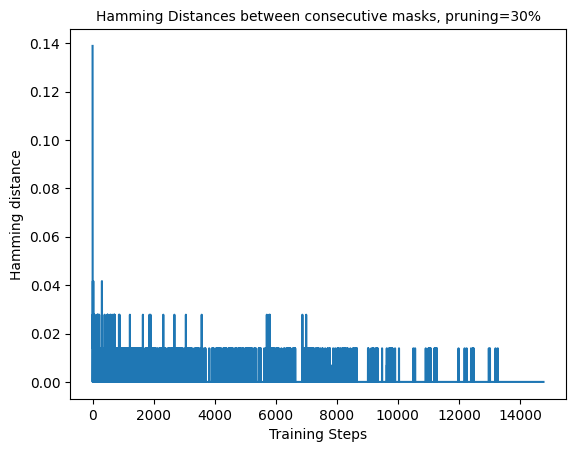

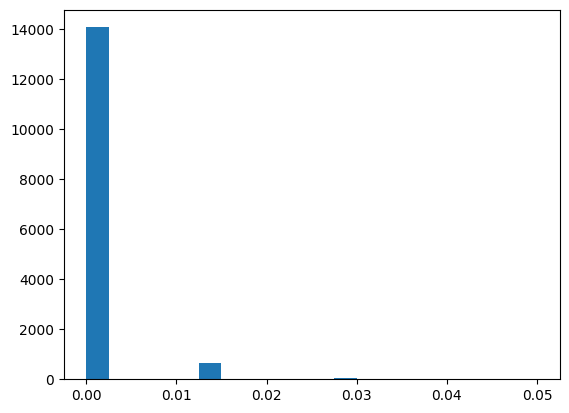

In [42]:
pruning_ratio=0.3
layers_masks = np.stack([compute_mask(self_coefs[:,step,:], method='layerwise', pruning_ratio=pruning_ratio) for step in range(self_coefs.shape[1])], axis=1)
distances = np.array([hamming_distance(layers_masks[:,i,:], layers_masks[:,i+1,:]) for i in range(1, layers_masks.shape[1]-1)])

plt.plot(distances)  # add border to markers
plt.title(f'Hamming Distances between consecutive masks, pruning={int(pruning_ratio*100)}%', fontsize=10)  # set title
plt.xlabel('Training Steps')
plt.ylabel('Hamming distance')
plt.savefig(f"{save_dir}/hamming_distances_p={pruning_ratio}.png")
plt.show()


# histogram of hamming distances
plt.hist(distances, bins=20, range=(0, .05))
plt.show()

In [ ]:
import torch
from torch import nn

class EarlyBird():
    def __init__(self, percent, epoch_keep=5, masks=None, thresh=0.1):
        self.percent = percent
        self.epoch_keep = epoch_keep
        self.masks = []
        self.dists = [1 for i in range(1, self.epoch_keep)]
        self.count=0
        self.masks_all = masks
        self.thresh=thresh
        
    def put(self, mask):
        if len(self.masks) < self.epoch_keep:
            self.masks.append(mask)
        else:
            self.masks.pop(0)
            self.masks.append(mask)

    def cal_dist(self):
        if len(self.masks) == self.epoch_keep:
            for i in range(len(self.masks)-1):
                mask_i = self.masks[-1]
                mask_j = self.masks[i]
                self.dists[i] = 1 - float(np.sum(mask_i==mask_j)) / len(mask_j.flatten())
            return True
        else:
            return False

    def early_bird_emerge(self, model):
        # mask = self.pruning(model, self.percent)
        mask = self.masks_all[:,self.count,:]
        self.count+=1
        self.put(mask)
        flag = self.cal_dist()
        if flag == True:
            for i in range(len(self.dists)):
                if self.dists[i] > self.thresh:
                    return False
            return True
        else:
            return False

In [ ]:
def draw_early_bird(slimming_coefs, pruning_ratio, epoch_keep=5, 
                    thresh=0.1, method='layerwise', verbose=True, step = 1):
    layers_masks = np.stack([compute_mask(slimming_coefs[:,step,:], pruning_ratio=pruning_ratio) for step in range(slimming_coefs.shape[1])], axis=1)
    quantile_axis = -1

    quantile_axis = -1 if method == 'layerwise' else None
    threshold = np.quantile(slimming_coefs, pruning_ratio, axis=quantile_axis, keepdims=True)
    layers_masks = slimming_coefs > threshold

    eb = EarlyBird(pruning_ratio, epoch_keep=epoch_keep, masks=layers_masks, thresh=thresh)

    for i in range(0, layers_masks.shape[1], step):
        if eb.early_bird_emerge(None):
            if verbose:
                print(f'Early bird emerges at step {i}')
            break

    return i

In [ ]:
# draw early birds for self attention heads
import itertools
from joblib import Parallel, delayed

pruning_ratios=[0.3,  0.8]
cached_masks = [5, 50, 100, 500, 1000, 2000]
thresh = [0.1, 0.05, 0.01, 0]
steps = [10, 25, 50]
combinations = itertools.product(pruning_ratios, cached_masks, thresh, steps)

epochs_drawn = Parallel(n_jobs=4)(delayed(draw_early_bird)(self_coefs, pruning_ratio, epoch_keep=cached_mask, thresh=th, method='layerwise', verbose=False, step=step) 
                                  for pruning_ratio, cached_mask, th, step in combinations)


In [ ]:
import pandas as pd

# Recreate the combinations as a list
combinations_list = list(itertools.product(pruning_ratios, cached_masks, thresh, steps))

# Create a DataFrame from the parameters and epochs drawn
df = pd.DataFrame(combinations_list, columns=['Pruning Ratio', 'Steps Keep', 'Threshold', 'Steps'])

# Add the epochs_drawn data assuming it's the same length as combinations_list
df['Epochs Drawn'] = epochs_drawn


# save to csv file
df.to_csv(f'{save_dir}/early_birds_selfslimming_steps.csv')

# # Filter the DataFrame for the specific pruning ratio
# pivot_table = df[df['Pruning Ratio'] == .2]

# # Pivot the table
# pivot_table = pivot_table.pivot(columns='Threshold', index='Steps Keep', values='Epochs Drawn')
# pivot_table


# Stationarity in MSA Slimming Coefficients

Visualize sliding slopes

In [ ]:
head=0
layer=0
end = self_coefs.shape[1]

start = 0
step = 500
window = 500
# window_smooth=100
t0 = start
t1 = start + (window-1)


plt.figure(figsize=(10, 8))
plt.title("Sliding window regressions - MSA slimming coefs. layer 0, head 0")
plt.plot(self_coefs[layer, :, head])
plt.xlabel('Steps')
plt.ylabel('Slimming Coefficients')

slopes=[]

while t1 < end:
    series = self_coefs[layer, t0:t1, head]
    # series = np.convolve(series, np.ones(window_smooth)/window_smooth, mode='valid')
    t = np.arange(t0, t1)
    fitted = sm.OLS(series, sm.add_constant(t)).fit()

    # plot the support of the fitted line
    intercept, slope = fitted.params

    slopes.append(slope)
    line = slope * t + intercept
    plt.plot(t, line, color='red')
    
    t0+=step
    t1+=step
    

### Different methods to identify change of trends / stationarity

In [ ]:
head=0
layer=0

smooth=False
window_smooth=100

series = self_coefs[layer, :, head]
end = series.shape[1]
print(end)
start = 0
step = 100
window = 500

tests = []
intervals = []


t0 = start
t1 = start + (window-1)

methods = ['mk', 'adf', 'db', 'autoreg', 'lin_reg']
results = {method: [] for method in methods}

while t1 < end:
    intervals.append((t0, t1))
    series = series[layer, t0:t1, head]
    # if smooth: series = np.convolve(series, np.ones(window_smooth)/window_smooth, mode='valid')
    
    results['mk'].append(mk.original_test(series[layer, t0:t1, head]))
    results['adf'].append(sm.tsa.adfuller(series[layer, t0:t1, head], autolag='AIC', regression='c'))
    results['db'].append(durbin_watson(series[layer, t0:t1, head]))

    # run an AR model
    # test_result = AutoReg(series, lags=1, old_names=False, trend='ct').fit()
    # test_result = AutoReg(endog=series, lags=0, exog=exogs, trend='n', old_names=False).fit()

    # linear regressio against trend including constant
    t = np.arange(len(series))
    results['lin_reg'].append(sm.OLS(series, sm.add_constant(t)).fit())
    
    t0 += step
    t1 = t0 + (window-1)
    
    

In [ ]:
# ar1 = [test.params[1] for test in tests]
# plt.plot(ar1)
# plt.show()
# plot the p-values
p_values = [reg.pvalues[1]*1000 for reg in results['lin_reg']]
plt.plot(p_values)
plt.show()

In [ ]:
# plot mk p-values
p_values = [results['mk'][i].p for i in range(len(intervals))]
plt.plot(p_values)
plt.show()

In [ ]:
# p < 0.05 means the series IS stationary (reject unit root hypothesis)
p_values = [results['adf'][i][1] for i in range(len(intervals))]
# plt.plot(p_values)
# plt.show()

# plot p<0.05 or not
binary_p = [results['adf'][i][1] < 0.05 for i in range(len(intervals))]
plt.plot(binary_p)
plt.show()

# Analysis of MSA nuclear norm masks and Stationarity metris

In [9]:

def norm(mask, ord='nuc'):
    return np.linalg.norm(mask, ord=ord)

def moving_average(y, window_size):
    return np.convolve(y, np.ones(window_size)/ window_size, mode='valid')

In [ ]:
pruning_ratio=0.2
layers_masks = np.stack([compute_mask(self_coefs[:,step,:], pruning_ratio=pruning_ratio) for step in range(self_coefs.shape[1])], axis=1)

norms = [norm(layers_masks[:,i,:], 'nuc') for i in range(1, layers_masks.shape[1]-1)]

plt.plot(norms, label='Nuclear Norm of MSA masks')
plt.plot(moving_average(norms, 500), label='Moving Average 500 steps', color='black')
plt.legend()
plt.xlabel('Training Steps')
plt.plot
plt.show()

Dynamic Chart Smoothed norm for different intervals

In [ ]:
%matplotlib inline
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import time  # Import time for sleep functionality
series =  norms
end = len(series)
start = 0
window_smooth=200
step = 100
window = 300

tests = []
intervals = []

t0 = start
t1 = t0 + (window) + (window_smooth-1)

fig, ax = plt.subplots(figsize=(10, 6))
frame = 0
while t1<end:
    y = series[t0:t1]
    y = np.convolve(y, np.ones(window_smooth) / window_smooth, mode='valid')

    ax.clear()  # Clear the axis to draw a new plot
    ax.plot(y)  # Plot the new segment
    ax.set_title(f"Plot from index {t0} to {t1}")
    ax.set_xlabel('Index within Window')
    ax.set_ylabel('Smoothed Value')

    display(fig)    # Display the figure
    clear_output(wait=True)  # Clear the output to make room for the next plot
    time.sleep(1)  # Pause for half a second before continuing to the next frame

    frame += 1  # Increment frame counter
    t0 += step
    t1 = t1 + step
    

plt.close(fig)  # Close the figure to clean up


Visualize sliding slopes

In [ ]:
start = 0
step = 100
window_smooth=200
step = 200
window = 300
end = len(series)


series = np.convolve(series, np.ones(window_smooth)/window_smooth, mode='valid')


t0 = start
t1 = t0 + (window) + (window_smooth-1)

plt.figure(figsize=(15, 10))
plt.plot(series)

slopes=[]
while t1 < end:
    y = series[t0:t1]
    t = np.arange(t0, t1)
    fitted = sm.OLS(y, sm.add_constant(t)).fit()

    # plot the support of the fitted line
    intercept, slope = fitted.params

    slopes.append(slope)
    line = slope * t + intercept
    plt.plot(t, line, color='red')
    
    t0+=step
    t1+=step
    

## Early-bird drawing - MSA 

In [12]:

def stationarity_measures(series, start=0, window_smooth=200, step=100, window=300):
    end = len(series)
    t0 = start
    t1 = t0 + (window) + (window_smooth-1)
    methods = ['mk', 'adf', 'db', 'lin_reg']
    results = {method: [] for method in methods}
    steps = []
    while t1 < end:
        y = series[t0:t1]
        if window_smooth > 0:
            y = np.convolve(y, np.ones(window_smooth)/window_smooth, mode='valid')
        results['mk'].append(mk.original_test(y))
        try:
            results['adf'].append(sm.tsa.adfuller(y, autolag='AIC', regression='c')[1])
        except:
            results['adf'].append(0)
        results['db'].append(durbin_watson(y))
        t = np.arange(len(y))
        results['lin_reg'].append(sm.OLS(y, sm.add_constant(t)).fit())
        t0 += step
        t1 = t0 + (window-1)
        steps.append(t1)
    return results, steps

In [16]:
def plot_p_values(steps, p_values, title, threshold=0.1, max_labels=8):
    plt.plot(steps, p_values, color='black')
    plt.title(title)
    plt.xlabel('Training Steps')
    
    # horizontal line at threshold
    if threshold > 0:
        plt.axhline(y=threshold, color='r', linestyle='--', label=str(threshold))

    # label the points above threshold with the corresponding steps
    above_threshold = p_values > threshold
    nlabels=0
    for step, p_value in zip(steps[above_threshold], p_values[above_threshold]):
        if nlabels >= max_labels:
            break
        plt.text(step, p_value, str(step), color='red', fontsize=6)
        nlabels += 1

    plt.show()

    # get indexes of p-values greater than threshold
    p_greater_than = np.where(p_values > threshold)[0]
    print(steps[p_greater_than])

In [69]:
pruning_ratio=0.8
layers_masks = np.stack([compute_mask(self_coefs[:,step,:], pruning_ratio=pruning_ratio) for step in range(self_coefs.shape[1])], axis=1)
norms = [norm(layers_masks[:,i,:], 'nuc') for i in range(1, layers_masks.shape[1]-1)]


self_stats, steps = stationarity_measures(norms, start=0, window_smooth=200, step=100, window=300)
steps=np.array(steps)

/home/mashalimay/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


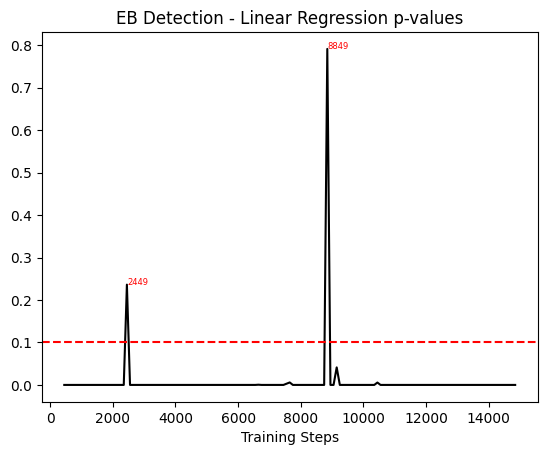

[2449 8849]


In [70]:
p_values = np.array([reg.pvalues[1] for reg in self_stats['lin_reg']])

plot_p_values(steps, p_values, 'EB Detection - Linear Regression p-values', threshold=.1)

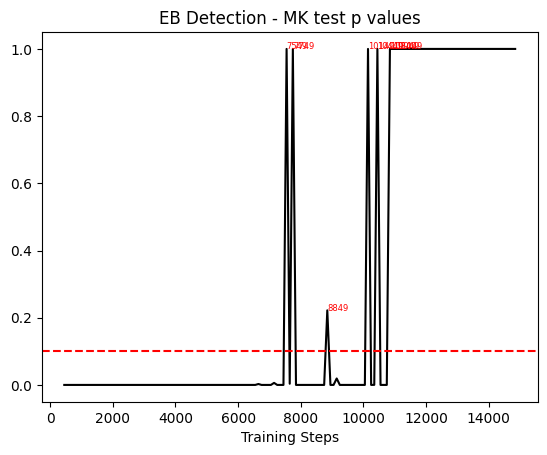

[ 7549  7749  8849 10149 10449 10849 10949 11049 11149 11249 11349 11449
 11549 11649 11749 11849 11949 12049 12149 12249 12349 12449 12549 12649
 12749 12849 12949 13049 13149 13249 13349 13449 13549 13649 13749 13849
 13949 14049 14149 14249 14349 14449 14549 14649 14749 14849]


In [71]:
# plot mk p-values
p_values = np.array([self_stats['mk'][i].p for i in range(len(steps))])

plot_p_values(steps, p_values, 'EB Detection - MK test p values', threshold=.1)

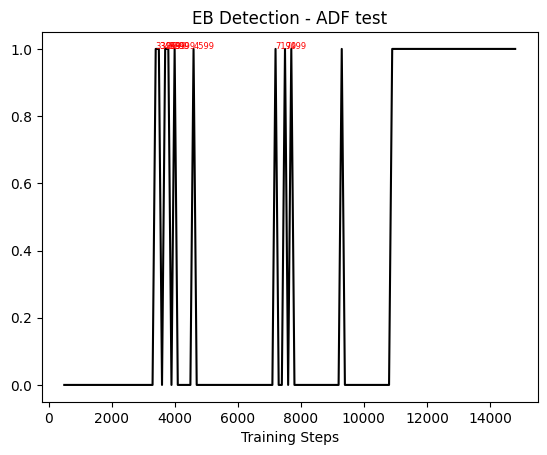

[ 3399  3499  3699  3799  3999  4599  7199  7499  7699  9299 10899 10999
 11099 11199 11299 11399 11499 11599 11699 11799 11899 11999 12099 12199
 12299 12399 12499 12599 12699 12799 12899 12999 13099 13199 13299 13399
 13499 13599 13699 13799 13899 13999 14099 14199 14299 14399 14499 14599
 14699 14799]


In [65]:

# p < 0.05 means the series IS stationary (reject unit root hypothesis)
p_values = np.array([self_stats['adf'][i] for i in range(len(steps))])
# plt.plot(p_values)
# plt.show()

# plot p<0.05 or not
binary_p = np.array([self_stats['adf'][i] < 0.05 for i in range(len(steps))])

plot_p_values(steps, binary_p, 'EB Detection - ADF test', threshold=0)

# Analysis - Intermediate MLP slimming coefficients

Hamming Distances are much more stable!

In [45]:
_, inter_coefs = load_and_plot(1, self=False, inter=True, plot=False, save=False)

slim_before: False, soft_by_one: False


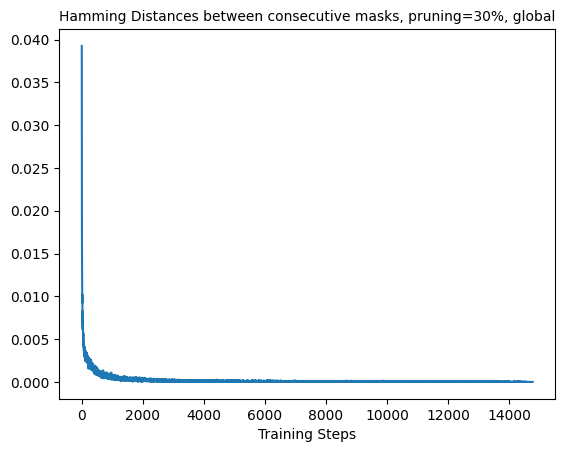

In [53]:
pruning_ratio=0.3
# similar results for layerwise or global pruning
layers_masks = np.stack([compute_mask(inter_coefs[:,step,:], method='global', pruning_ratio=pruning_ratio) for step in range(self_coefs.shape[1])], axis=1)
distances = np.array([hamming_distance(layers_masks[:,i,:], layers_masks[:,i+1,:]) for i in range(1, layers_masks.shape[1]-1)])
plt.plot(distances[2:])  # remove first initial ones for better plot
plt.title(f'Hamming Distances between consecutive masks, pruning={int(pruning_ratio*100)}%, global', fontsize=10)  # set title
plt.xlabel('Training Steps')
# plt.ylabel('Hamming distance')
plt.savefig(f"{save_dir}/hamming_distances_p={pruning_ratio}.png")
plt.show()



In [27]:
pruning_ratio = 0.3
masks_inter = np.stack([compute_mask(inter_coefs[:,step,:], method='global', pruning_ratio=pruning_ratio) for step in range(inter_coefs.shape[1])], axis=1)

In [28]:
norms_inter = [norm(masks_inter[:,i,:], 'nuc') for i in range(1, masks_inter.shape[1]-1)]

In [ ]:
window_smooth=300
norms_smoothed = np.convolve(norms_inter, np.ones(window_smooth)/window_smooth, mode='valid')
plt.plot(norms_inter)
plt.plot(norms_smoothed)
plt.show()

In [34]:
inter_stats, steps = stationarity_measures(norms_inter, start=0, window_smooth=0, step=100, window=300)
steps=np.array(steps)

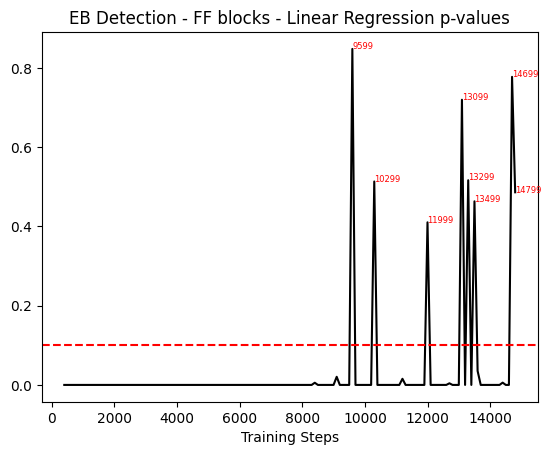

[ 9599 10299 11999 13099 13299 13499 14699 14799]


In [35]:
p_values = np.array([reg.pvalues[1] for reg in inter_stats['lin_reg']])

plot_p_values(steps, p_values, 'EB Detection - FF blocks - Linear Regression p-values', threshold=.1)


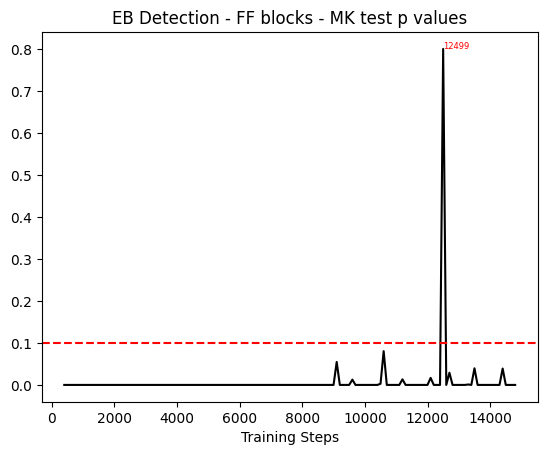

[12499]


In [32]:
p_values = np.array([inter_stats['mk'][i].p for i in range(len(steps))])

plot_p_values(steps, p_values, 'EB Detection - FF blocks - MK test p values', threshold=.1)


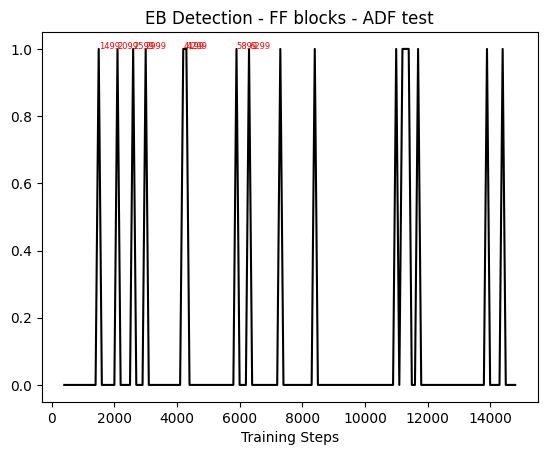

[ 1499  2099  2599  2999  4199  4299  5899  6299  7299  8399 10999 11199
 11299 11399 11699 13899 14399]


In [24]:
p_values = np.array([inter_stats['adf'][i] for i in range(len(steps))])

p_binary = np.array([p < 0.05 for p in p_values])

plot_p_values(steps, p_binary, 'EB Detection - FF blocks - ADF test', threshold=0)

# TODO - Other Stationarity Identification Stategies

In [ ]:

# TODO: markov-switching model
import numpy as np
from hmmlearn import hmm


head = 0
layer = 0

end = self_coefs.shape[1]

start = 0
step = 100
window = 500

# Initialize the storage for probabilities
transition_probs = []
intervals = []

# Define initial probabilities if known, otherwise, you can start with uniform probabilities
initial_probabilities = np.array([0.5, 0.5])

# Process each window of data
t0 = start
t1 = start + (window-1)

while t1 < end:
    intervals.append((t0, t1))
    series = self_coefs[layer, t0:t1, head].reshape(-1, 1)

    # Create and fit the HMM
    model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
    # model.startprob_ = initial_probabilities
    model.fit(series)

    if model.monitor_.converged:
        transmat = model.transmat_
        covars = model.covars_ # np.diag(model.covars_)

        # Identify states based on variance or other criteria
        state_constant = np.argmin(covars)
        state_trend = np.argmax(covars)  

        # Probability of transitioning from trend to constant
        prob_trend_to_constant = transmat[state_trend, state_constant]
        transition_probs.append(1-prob_trend_to_constant)
        
    # Move to the next window
    t0 += step
    t1 = t0 + (window-1)

plt.plot(transition_probs)

In [ ]:
from bayesian_changepoint_detection.priors import const_prior
from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll
from functools import partial



head = 0
layer = 0

end = self_coefs.shape[1]

start = 0
step = 100
window = 500

# Initialize the storage for probabilities
transition_probs = []

# Process each window of data
t0 = start
t1 = start + (window-1)
while t1 < end:
    series = self_coefs[layer, t0:t1, head].reshape(-1, 1)
    prior_function = partial(const_prior, p=1/(len(series) + 1))
    
    # Create and fit the HMM
    Q, P, Pcp = offline_changepoint_detection(series, prior_function, offline_ll.StudentT(), truncate=-40)
    transition_probs.append(np.exp(Pcp).sum())
    t0 += step
    t1 = t0 + (window-1)


In [ ]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import breaks_cusumolsresid

# Assuming 'y' is your dependent variable and 'X' is a matrix of regressors
X = sm.add_constant(X)  # Add an intercept term to the model
model = sm.OLS(y, X)
results = model.fit()

# Run CUSUM test on residuals
test_stat, critical_values, pvalue = breaks_cusumolsresid(results.resid)
print("CUSUM test statistic:", test_stat)
print("p-value:", pvalue)

In [ ]:
# TODO: implement cusum changepoint detection for dy

dy = np.diff(self_coefs[layer, :, head])
plt.plot(dy)


def cusum_for_stability(dy, threshold=5):
    S_pos, S_neg = 0, 0
    stable_points = []

    for i, change in enumerate(dy):
        if change > 0:
            S_pos += change
            S_neg = 0  # reset negative CUSUM
        elif change < 0:
            S_neg += abs(change)
            S_pos = 0  # reset positive CUSUM
        else:
            # When dy is zero, check for stability
            if S_pos < threshold and S_neg < threshold:
                stable_points.append(i)

        # Reset if thresholds are exceeded
        if S_pos > threshold:
            S_pos = 0
        if S_neg > threshold:
            S_neg = 0

    return stable_points



stable_points = cusum_for_stability(dy)
print("Stable points detected at indices:", stable_points)

plt.plot(dy, label='dy')
plt.scatter(stable_points, dy[stable_points], c='red', label='Stable Points')
plt.axhline(0, color='gray', lw=0.5)
plt.legend()
plt.show()